In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from optbinning import OptimalBinning

# Import the data
accepts = pd.read_csv('/Users/suyeonkim/Documents/IAA/Spring 1/Financial Analytics/Homework1_FA/accepted_customers.csv')
rejects = pd.read_csv('/Users/suyeonkim/Documents/IAA/Spring 1/Financial Analytics/Homework1_FA/rejected_customers.csv')

# Split into train and test
train, test = train_test_split(accepts, test_size = 0.30, random_state = 1234)


# EDA & Data Cleaning

In [13]:
missing_values = accepts.isnull().sum()
missing_values

CHILDREN      0
PERS_H        0
AGE           0
TMADD         0
TMJOB1        0
TEL           0
NMBLOAN       0
FINLOAN       0
INCOME        0
EC_CARD       0
BUREAU        0
LOCATION      0
LOANS         0
REGN          0
DIV           0
CASH          0
PRODUCT      12
RESID       535
NAT           0
PROF          1
CAR           0
CARDS         0
GB            0
_freq_        0
dtype: int64

In [14]:
#Impute N/A
accepts = accepts.fillna("Missing")

In [15]:
# Check there is no missing value anymore
missing_values = accepts.isnull().sum()
missing_values

CHILDREN    0
PERS_H      0
AGE         0
TMADD       0
TMJOB1      0
TEL         0
NMBLOAN     0
FINLOAN     0
INCOME      0
EC_CARD     0
BUREAU      0
LOCATION    0
LOANS       0
REGN        0
DIV         0
CASH        0
PRODUCT     0
RESID       0
NAT         0
PROF        0
CAR         0
CARDS       0
GB          0
_freq_      0
dtype: int64

In [16]:
# Define categorical and continuous variables
continuous_variables = ['CASH', 'CHILDREN', 'INCOME', 'LOANS', 'TMADD', 'TMJOB1']
categorical_variables = ["BUREAU", "CAR", "CARDS", "DIV", "EC_CARD", "FINLOAN", "LOCATION", 
                         "PRODUCT", "PROF", "REGN", "RESID", "TEL"]

# Encode categorical variables as numeric
df_encoded = accepts.copy()
for col in categorical_variables:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes + 1

# Combine continuous and encoded categorical variables
all_variables = continuous_variables + categorical_variables

# Calculate the correlation matrix
correlation_matrix = df_encoded[all_variables].corr()

# Find pairs with correlation > 0.5
high_corr_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            high_corr_pairs.append({
                'Variable 1': correlation_matrix.index[i],
                'Variable 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

# Convert to DataFrame for better visualization
high_corr_pairs_df = pd.DataFrame(high_corr_pairs)

# Display the result
if high_corr_pairs_df.empty:
    print("No variable pairs with correlation greater than 0.5.")
else:
    print("High Correlation Pairs (Correlation > 0.5):")
    print(high_corr_pairs_df)

High Correlation Pairs (Correlation > 0.5):
  Variable 1 Variable 2  Correlation
0      LOANS     BUREAU    -0.647963
1      CARDS    EC_CARD    -0.957574
2        DIV       REGN     0.686616


In [17]:
# Find optimal binning
from optbinning import BinningProcess

colnames =  list(train.columns[0:2]) + list(train.columns[3:18]) + list(train.columns[19:22])

# Drop highly correlated columns
colnames = [x for x in colnames if x != 'EC_CARD']
colnames = [x for x in colnames if x != 'BUREAU']
colnames = [x for x in colnames if x != 'DIV']
X = train[colnames]
y = train["GB"]

# Select important variables
selection_criteria = {"iv": {"min": 0.1, "max": 1}}

bin_proc = BinningProcess(colnames, selection_criteria = selection_criteria, categorical_variables = ["BUREAU", "CAR", "CARDS", "DIV", "EC_CARD", "FINLOAN", "LOCATION", "NAT", "PRODUCT", "PROF", "REGN", "RESID", "TEL"])

iv_all = bin_proc.fit(X, y).summary()

iv_all[iv_all.columns[0:6]].sort_values(by = ["iv"], ascending = False)

,name,dtype,status,selected,n_bins,iv
7,INCOME,numerical,OPTIMAL,True,8,0.268925
16,CARDS,categorical,OPTIMAL,True,2,0.189327
3,TMJOB1,numerical,OPTIMAL,True,8,0.17702
1,PERS_H,numerical,OPTIMAL,True,4,0.176798
4,TEL,categorical,OPTIMAL,False,2,0.057385
0,CHILDREN,numerical,OPTIMAL,False,4,0.047069
14,PROF,categorical,OPTIMAL,False,4,0.045712
2,TMADD,numerical,OPTIMAL,False,4,0.040261
11,CASH,numerical,OPTIMAL,False,6,0.035454
15,CAR,categorical,OPTIMAL,False,2,0.034375


In [18]:
from optbinning import Scorecard
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(solver = "lbfgs")

scorecard = Scorecard(binning_process = bin_proc,
                      estimator = estimator, scaling_method = "pdo_odds",
                      scaling_method_params = {"pdo": 50, 
                      "scorecard_points": 500, "odds": 20})
                    

scorecard.fit(X, y, sample_weight = train["_freq_"])

Scorecard(binning_process=BinningProcess(categorical_variables=['BUREAU', 'CAR',
                                                                'CARDS', 'DIV',
                                                                'EC_CARD',
                                                                'FINLOAN',
                                                                'LOCATION',
                                                                'NAT',
                                                                'PRODUCT',
                                                                'PROF', 'REGN',
                                                                'RESID',
                                                                'TEL'],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.1}},
                                         variable_names=['CHILDREN', 'PERS_H',
                                                         'TMADD', 'TMJOB1',
                                                         'TEL', 'NMBLOAN',
                                                         'FINLOAN', 'INCOME',
                                                         'LOCATION', 'LOANS',
                                                         'REGN', 'CASH',
                                                         'PRODUCT', 'RESID',
                                                         'PROF', 'CAR',
                                                         'CARDS']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 20, 'pdo': 50,
                                 'scorecard_points': 500})

In [19]:
scorecard.table(style = "detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,PERS_H,0,"(-inf, 1.50)",9132,0.279309,8640,492,0.053876,-0.545042,0.107824,1.331366e-02,-0.798730,101.058373
1,PERS_H,1,"[1.50, 2.50)",8309,0.254137,8130,179,0.021543,0.405209,0.034678,4.305319e-03,-0.798730,155.808216
2,PERS_H,2,"[2.50, 4.50)",13150,0.402202,12840,310,0.023574,0.313027,0.034131,4.249087e-03,-0.798730,150.497035
3,PERS_H,3,"[4.50, inf)",2104,0.064352,2040,64,0.030418,0.051101,0.000164,2.050805e-05,-0.798730,135.405845
4,PERS_H,4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.798730,132.461615
5,PERS_H,5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.798730,132.461615
0,TMJOB1,0,"(-inf, 7.50)",1820,0.055666,1710,110,0.060440,-0.666953,0.034171,4.193946e-03,-0.804026,93.779538
1,TMJOB1,1,"[7.50, 10.50)",1363,0.041688,1290,73,0.053558,-0.538783,0.015678,1.936336e-03,-0.804026,101.213155
2,TMJOB1,2,"[10.50, 16.50)",2574,0.078728,2460,114,0.044289,-0.339003,0.010633,1.322809e-03,-0.804026,112.800044
3,TMJOB1,3,"[16.50, 31.50)",5490,0.167916,5280,210,0.038251,-0.186147,0.006354,7.930601e-04,-0.804026,121.665399


Plotting WOE for CASH


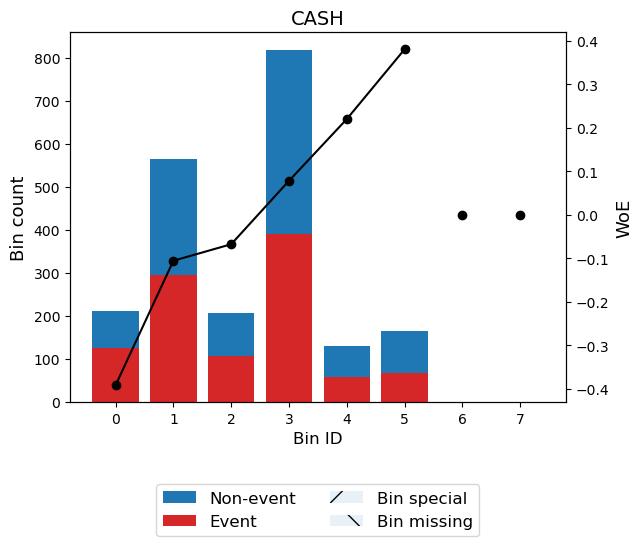

Plotting WOE for CHILDREN


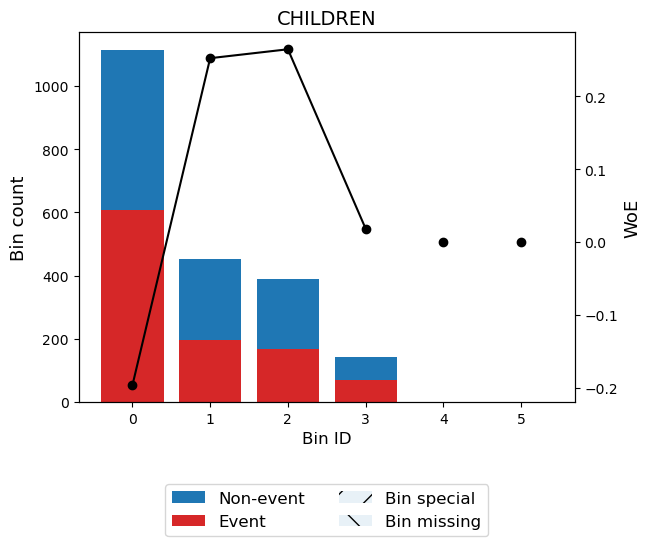

Plotting WOE for INCOME


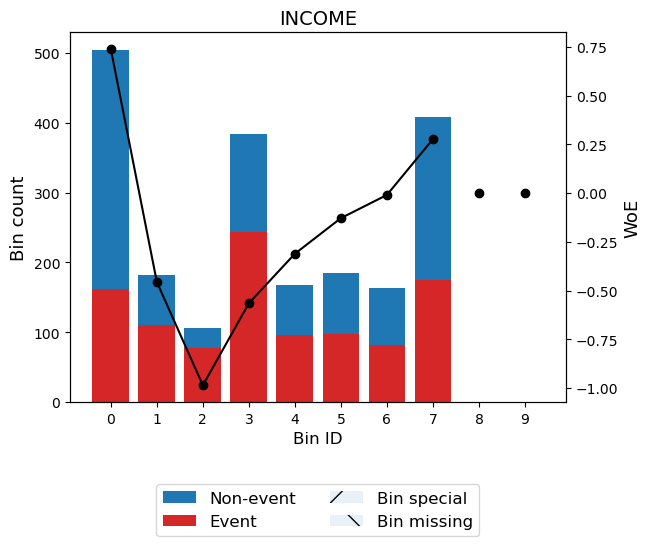

Plotting WOE for LOANS


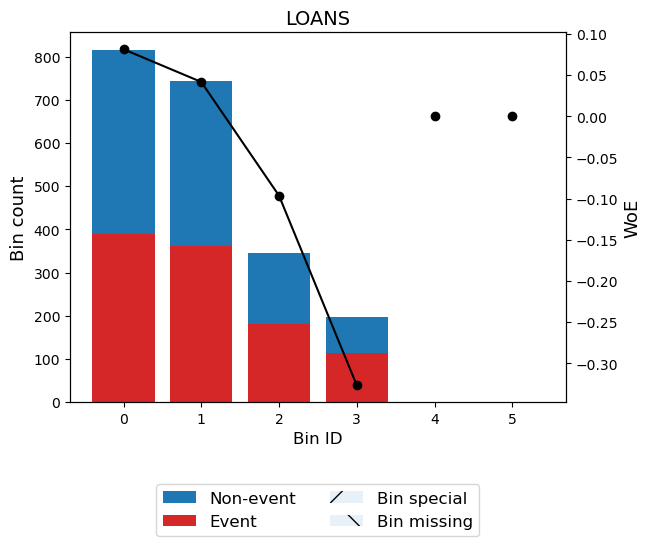

Plotting WOE for TMADD


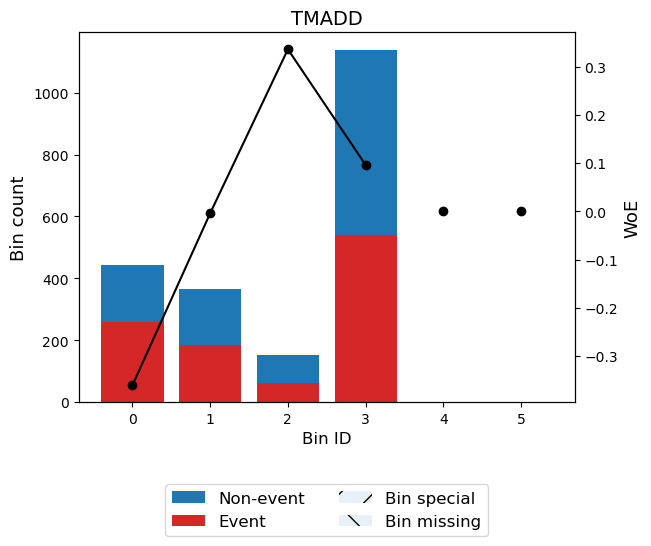

Plotting WOE for TMJOB1


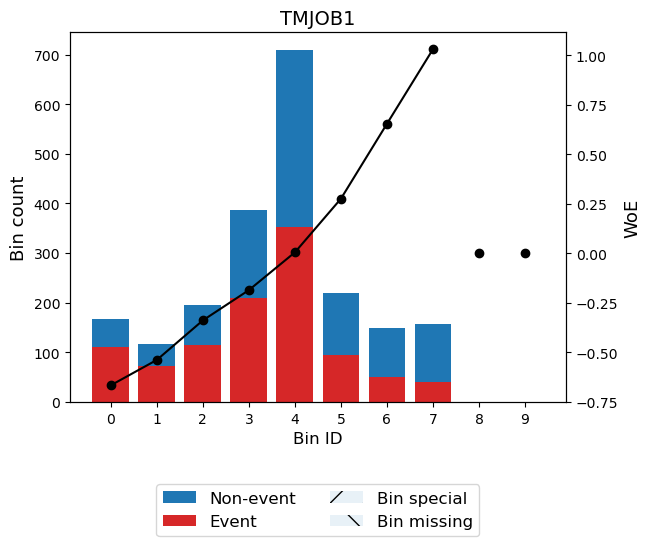

In [20]:
# Plot WOE
results = {}
iv_tables = {}

for var in continuous_variables:
    X = train[var]
    y = train["GB"]
    
    optbin = OptimalBinning(name=var, dtype="numerical")
    
    optbin.fit(X, y)
    
    results[var] = optbin

    iv_table = optbin.binning_table
    iv_tables[var] = iv_table.build()


for var in continuous_variables:
    print(f"Plotting WOE for {var}")
    results[var].binning_table.plot(metric="woe")

In [24]:
#Model Evaluation

from matplotlib import pyplot as plt
from optbinning import Scorecard
from sklearn.linear_model import LogisticRegression
from optbinning.scorecard import plot_auc_roc, plot_ks


In [28]:
X = train[colnames]
y = train["GB"]

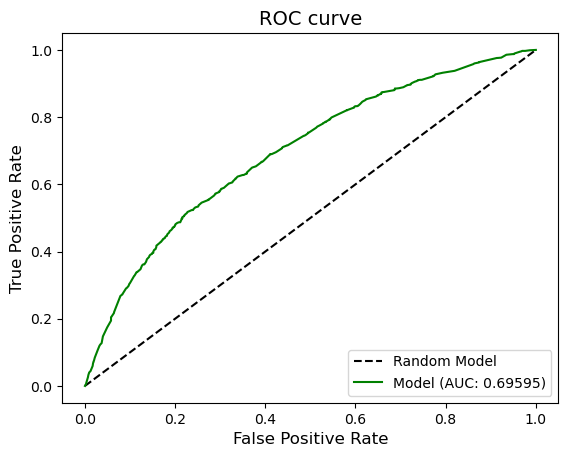

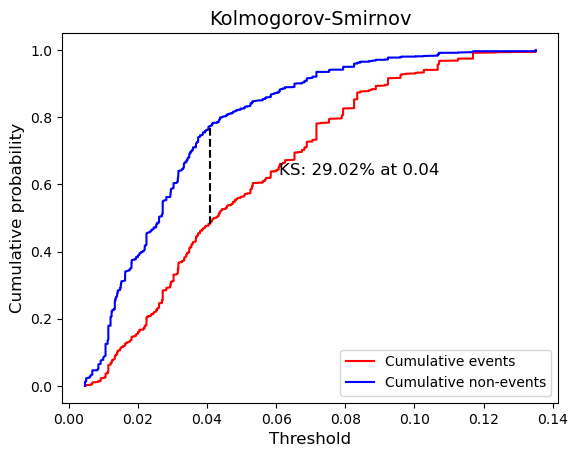

In [30]:

y_pred = scorecard.predict_proba(X)[:, 1]
plot_auc_roc(y, y_pred)
plt.show()

plot_ks(y, y_pred)
plt.show()



In [31]:
scorecard.table(style = "summary")

,Variable,Bin,Points
0,PERS_H,"(-inf, 1.50)",101.058373
1,PERS_H,"[1.50, 2.50)",155.808216
2,PERS_H,"[2.50, 4.50)",150.497035
3,PERS_H,"[4.50, inf)",135.405845
4,PERS_H,Special,132.461615
5,PERS_H,Missing,132.461615
0,TMJOB1,"(-inf, 7.50)",93.779538
1,TMJOB1,"[7.50, 10.50)",101.213155
2,TMJOB1,"[10.50, 16.50)",112.800044
3,TMJOB1,"[16.50, 31.50)",121.665399


In [32]:
#Reject Inference

X_r = rejects

rejects["y_pred"] = scorecard.predict_proba(X_r)[:, 1]

rejects["GB"] = (rejects["y_pred"] > 0.04).astype(int)
rejects["weight"] = rejects["GB"].apply(lambda x: 30 if x == 0 else 1)

rejects = rejects.drop("y_pred", axis=1)

comb_hard = pd.concat([accepts, rejects.head(1000)], ignore_index=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

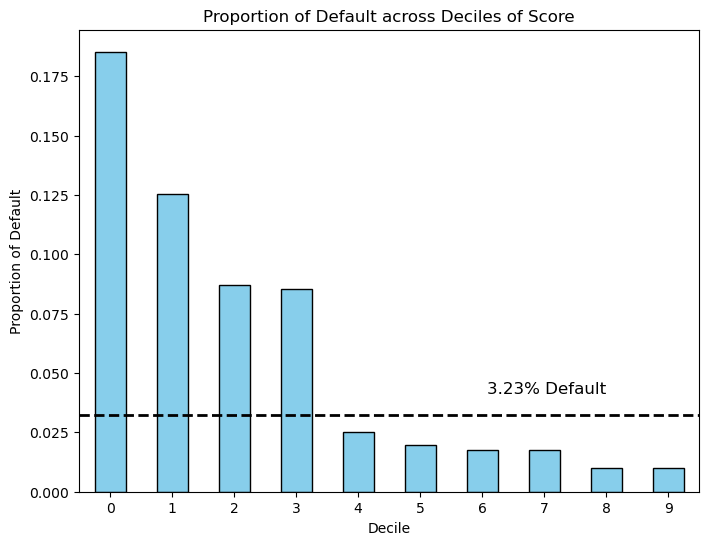

In [33]:
#Final Scorecard
test_final = comb_hard

test_final["score"] = scorecard.score(test_final)
test_final['decile'] = pd.qcut(test_final["score"], 10, labels = False, duplicates='drop')

PD = test_final[test_final['GB'] == 1].groupby('decile').size() / (test_final[test_final['GB'] == 0].groupby('decile').size() * 30 + test_final[test_final['GB'] == 1].groupby('decile').size())


plt.figure(figsize = (8, 6))
PD.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.axhline(y = 0.0323, color = 'black', linestyle = '--', linewidth = 2)
plt.text(x = 8, y = 0.04, s = '3.23% Default', color = 'black', ha = 'right', va = 'bottom', fontsize = 12)

plt.title('Proportion of Default across Deciles of Score')
plt.xlabel('Decile')
plt.ylabel('Proportion of Default')
plt.xticks(rotation = 0)

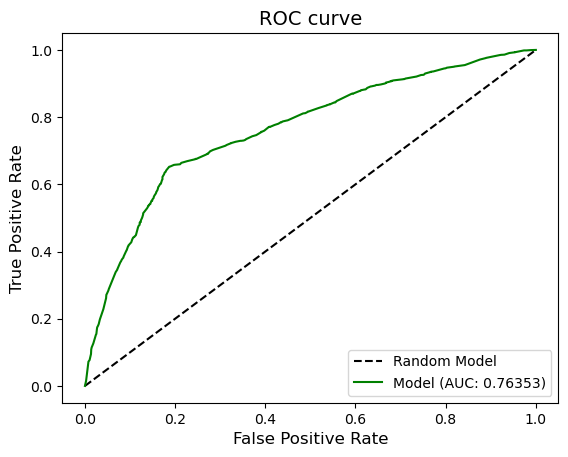

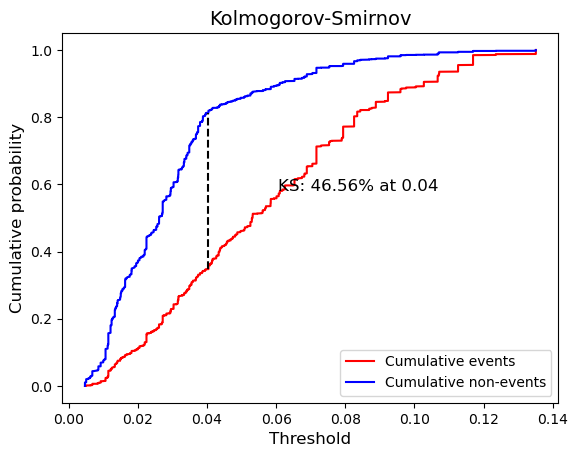

In [34]:
colnames =  list(train.columns[0:2]) + list(train.columns[3:18]) + list(train.columns[19:22])
X = test_final[colnames]
y = test_final["GB"]

y_pred = scorecard.predict_proba(X)[:, 1]

plot_auc_roc(y, y_pred)
plt.show()

plot_ks(y, y_pred)
plt.show()

Optimal Threshold: 0.04041871015602394


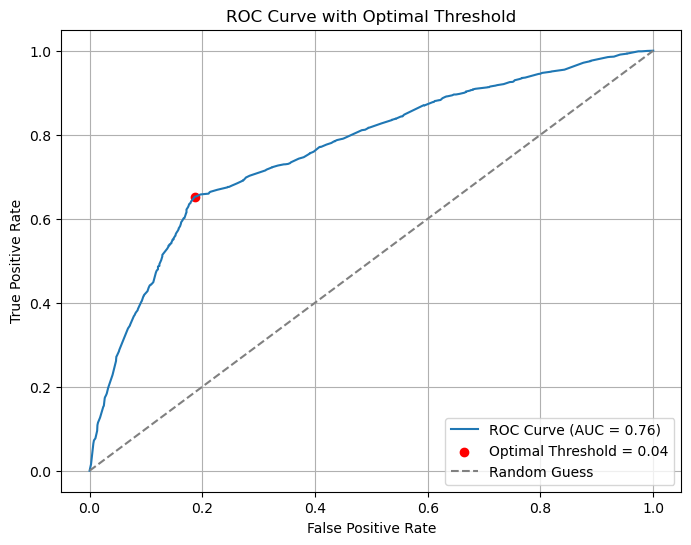

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred)

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr

# Find the index of the maximum J statistic
optimal_idx = youden_j.argmax()

# Get the optimal threshold
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve with the optimal threshold marked
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y, y_pred):.2f})")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Choose the optimal threshold or a custom threshold
threshold = optimal_threshold  # or use another value like 0.5

# Convert predicted probabilities to binary predictions based on the threshold
y_pred_binary = (y_pred >= threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y, y_pred_binary)

# Alternatively, print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1575  362]
 [ 717 1346]]


In [37]:
import plotly.graph_objects as go
import numpy as np

# Get the minimum and maximum score values
score_min = test_final['score'].min()
score_max = test_final['score'].max()

# Generate thresholds
thresholds = np.linspace(score_min, score_max, 100)

# Initialize lists to store results
acceptance_rates = []
default_rates = []

# Total weight in the dataset
total_weight = test_final['_freq_'].sum()

for threshold in thresholds:
    # Select the customers whose score is greater than or equal to the threshold
    accepted = test_final[test_final['score'] >= threshold]
    
    # Calculate the total weight for accepted customers
    accepted_weight = accepted['_freq_'].sum()
    
    # Calculate the weighted acceptance rate
    acceptance_rate = accepted_weight / total_weight
    acceptance_rates.append(acceptance_rate)
    
    # Calculate the total weight for defaults (GB == 1) among accepted customers
    default_weight = accepted[accepted['GB'] == 1]['_freq_'].sum()
    
    # Calculate the weighted default rate
    default_rate = default_weight / accepted_weight if accepted_weight > 0 else 0
    default_rates.append(default_rate)

# Create the figure
fig = go.Figure()

# Add the acceptance rate trace
fig.add_trace(go.Scatter(
    x=thresholds,
    y=acceptance_rates,
    mode='lines',
    name='Acceptance Rate',
    line=dict(color='skyblue')
))

# Add the default rate trace
fig.add_trace(go.Scatter(
    x=thresholds,
    y=default_rates,
    mode='lines',
    name='Bad Rate',
    line=dict(color='salmon'),
    yaxis='y2'
))

# Update the layout
fig.update_layout(
    title='Acceptance Rate and Bad Rate at Different Scorecard Values',
    xaxis=dict(title='Scorecard Value'),
    yaxis=dict(
        title='Acceptance Rate',
        titlefont=dict(color='skyblue'),
        tickfont=dict(color='skyblue')
    ),
    yaxis2=dict(
        title='Bad Rate',
        titlefont=dict(color='salmon'),
        tickfont=dict(color='salmon'),
        overlaying='y',
        side='right'
    ),
    template='plotly_white',
    width = 800,
    height = 500
)

fig.update_layout(showlegend=False)

# Show the figure
fig.show()


In [38]:
import plotly.graph_objects as go
import numpy as np

# Assuming test_final contains the scorecard values in 'score', the target variable 'GB' (1 for default, 0 for non-default),
# and the weight of each record in 'weights'

# Define the thresholds you want to consider for acceptance (e.g., ranging from the minimum to the maximum score)
score_min = test_final['score'].min()
score_max = test_final['score'].max()

# Define expected revenue and cost
expected_revenue = 2000
expected_cost = 52000

# Generate a list of threshold values between the min and max score
thresholds = np.linspace(score_min, score_max, 100)

# Calculate acceptance rate, default rate, and profit for each threshold
acceptance_rates = []
default_rates = []
profits = []

# Calculate the total weight for normalization
total_weight = test_final['_freq_'].sum()

for threshold in thresholds:
    # Select the customers whose score is greater than or equal to the threshold
    accepted = test_final[test_final['score'] >= threshold]
    
    # Calculate the weighted acceptance rate
    accepted_weight = accepted['_freq_'].sum()
    acceptance_rate = accepted_weight / total_weight
    acceptance_rates.append(acceptance_rate)
    
    # Calculate the weighted default rate for the accepted customers
    default_weight = accepted[accepted['GB'] == 1]['_freq_'].sum()
    default_rate = default_weight / accepted_weight if accepted_weight > 0 else 0
    default_rates.append(default_rate)
    
    # Calculate the weighted profit
    accepted_good_weight = accepted[accepted['GB'] == 0]['_freq_'].sum()
    accepted_default_weight = default_weight  # Already calculated above
    
    revenue = accepted_good_weight * expected_revenue
    cost = accepted_default_weight * expected_cost
    profit = revenue - cost
    profits.append(profit)

# Create a Plotly figure
fig = go.Figure()

# Plot Acceptance Rate on the left y-axis
fig.add_trace(go.Scatter(
    x=thresholds,
    y=acceptance_rates,
    mode='lines',
    name='Acceptance Rate (%)',
    line=dict(color='skyblue')
))

# Plot Profit on a separate right y-axis
fig.add_trace(go.Scatter(
    x=thresholds,
    y=profits,
    mode='lines',
    name='Profit',
    line=dict(color='green'),
    yaxis='y2'
))

# Update layout to have dual axes
fig.update_layout(
    title='Acceptance Rate and Profit at Different Scorecard Values',
    xaxis=dict(title='Scorecard Value'),
    yaxis=dict(
        title='Acceptance Rate (%)',
        titlefont=dict(color='skyblue'),
        tickfont=dict(color='skyblue')
    ),
    yaxis2=dict(
        title='Profit',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
        overlaying='y',
        side='right'
    ),
    template='plotly_white',
     width = 800,
    height = 500
)

fig.update_layout(showlegend=False)


# Show the plot
fig.show()
